# eGSIM API - Examples

Note: as of September 2023, the current API version (2.0) will be soon superseded by a new API that aims to return residuals data not bound to a specific plot but appended as as new column(s) of the passed flatfile. This format allows for more flexibility when processing eGSIM data

## Definitions

 <img align="right" width="500px" src="https://darvishdarab.github.io/cs421_f20/assets/images/client-server-1-d85a93ea16590c10bed340dd78294d0d.png"></img>

- client: the entity requesting data (e.g., this notebook)
- server: the entity serving the data (eGSIM) 
- request: the request that a client performs to get data from a server. A request is composed of:
   1. an endpoint (https address, or URL)
   2. parameters (optional) - e.g. which models or intensity measures we want to compute the residuals for
   3. uploaded file(s) (optional) - e.g. the flatfile of observed data we want to compute the residuals from
   4. a method. eGSIM supports: 
      1. GET request (`requests.get`), where a single URL encodes also the request parameters
      2. POST request (`requests.post`, exemplified in this notebook), where the URL is separated from the parameters and files. POST requests are slightly more complex but more flexible than GET requests: for instance, you cannot upload a flatfile with a GET request.
- response: the response that a server returns to a client request. A response is composed of:
    1. a body containing the requested data - e.g. the residuals computed by eGSIM
    2. a status code (integer in [100, 599]), indicating if the request has been successfully processed by the server. In case of unsuccessful response, eGSIM will provide useful information (in JSON format) inside the response body. To check if a request is successful, users can check the response status code or simply use `response.raise_for_status()` (see examples below), which will raise an `HTTPError` as normal Python exception. Bare in mind that `HTTPError`s occur when the server succesfully receives the requests but cannot process it, but there might be several errors occurring before the server even gets to process the request (e.g. connection problems), and it is thus always useful to `try-catch` a request to track errors

In [1]:
# define imports and global notebook variables:
# flatfile path
import os
data_path = os.path.join(os.path.dirname(os.getcwd()), 'data', 'flatfiles')
flatfile_path = os.path.join(data_path, 'example_flatfile.csv')
assert os.path.isfile(flatfile_path)
# define the eGSIM URL to query for residuals
url = "https://egsim.gfz-potsdam.de/query/residuals"
# we use the requests library (already installed with notebook and recommended to facilitate the usage of the eGSIM API):
import requests
# matpolotlib's pyplot for plotting data:
import matplotlib.pyplot as plt
# define a way to pretty print json:
import json
def pretty_print(json_data):
    print(json.dumps(json_data, indent=2))
# define our model(s) and intensity measure(s) of interest:
models = ['BindiEtAl2017Rjb', 'CauzziEtAl2014']  # FIXME: is there a list of available models? let alone the eGSIM web GUI
imts = ['PGA', 'SA(0.1)']

## Residuals request (with error)

In [2]:
with open(flatfile_path,'rb') as flatfile:
    json_response = None
    files = {'flatfile': flatfile}
    # let's provide a typo in the model(s), and miss the required parameter 'plot':
    parameters = {'model': ['BindiEtAl2017Rjub'], 'imt': imts}
    try:
        response = requests.post(url, files=files, data=parameters)
        # response body (in JSON format):
        json_response = response.json()
        # we could check `response.status_code`, or simply treat HttpErrors as a Python exception:
        response.raise_for_status()  # https://requests.readthedocs.io/en/latest/user/quickstart/#errors-and-exceptions
    except Exception:
        raise
    finally:
        if json_response is not None:
            # print the response (including when we have an HTTP error)
            pretty_print(json_response)

{
  "error": {
    "errors": [
      {
        "location": "model",
        "message": "Value not found or misspelled: BindiEtAl2017Rjub",
        "reason": "invalid_choice"
      },
      {
        "location": "plot",
        "message": "This parameter is required",
        "reason": "required"
      }
    ],
    "message": "Invalid request. Problems found in: model, plot. See response data for details",
    "code": 400
  }
}


HTTPError: 400 Client Error: Bad Request for url: https://egsim.gfz-potsdam.de/query/residuals

## Residuals request (distribution)

In [3]:
with open(flatfile_path,'rb') as flatfile:
    try:
        json_response = None
        files = {'flatfile': flatfile}
        parameters = {'model': models, 'imt': imts, 'plot': 'res'}
        response = requests.post(url, files=files, data=parameters)
        # response body (in JSON format):
        json_response = response.json()
        # we could check `response.status_code`, or simply treat HttpErrors as a Python exception:
        response.raise_for_status()
    except Exception:
        raise
    finally:
        if json_response is not None:
            # print the response (including when we have an HTTP error)
            pretty_print(json_response)

{
  "PGA": {
    "Inter event": {
      "BindiEtAl2017Rjb": {
        "mean": 0.42968774428586093,
        "stddev": 0.11887050383123549,
        "xlabel": "Z (PGA)",
        "ylabel": "Frequency",
        "median": null,
        "slope": null,
        "intercept": null,
        "pvalue": null,
        "xvalues": [
          0.0,
          0.5
        ],
        "yvalues": [
          1.0,
          1.0
        ]
      },
      "CauzziEtAl2014": {
        "mean": -1.6563671903590285,
        "stddev": 0.12164665397899233,
        "xlabel": "Z (PGA)",
        "ylabel": "Frequency",
        "median": null,
        "slope": null,
        "intercept": null,
        "pvalue": null,
        "xvalues": [
          -2.0,
          -1.5
        ],
        "yvalues": [
          2.0,
          0.0
        ]
      }
    },
    "Total": {
      "BindiEtAl2017Rjb": {
        "mean": 0.26714663662197863,
        "stddev": 0.8477393118621435,
        "xlabel": "Z (PGA)",
        "ylabel": "Frequency"

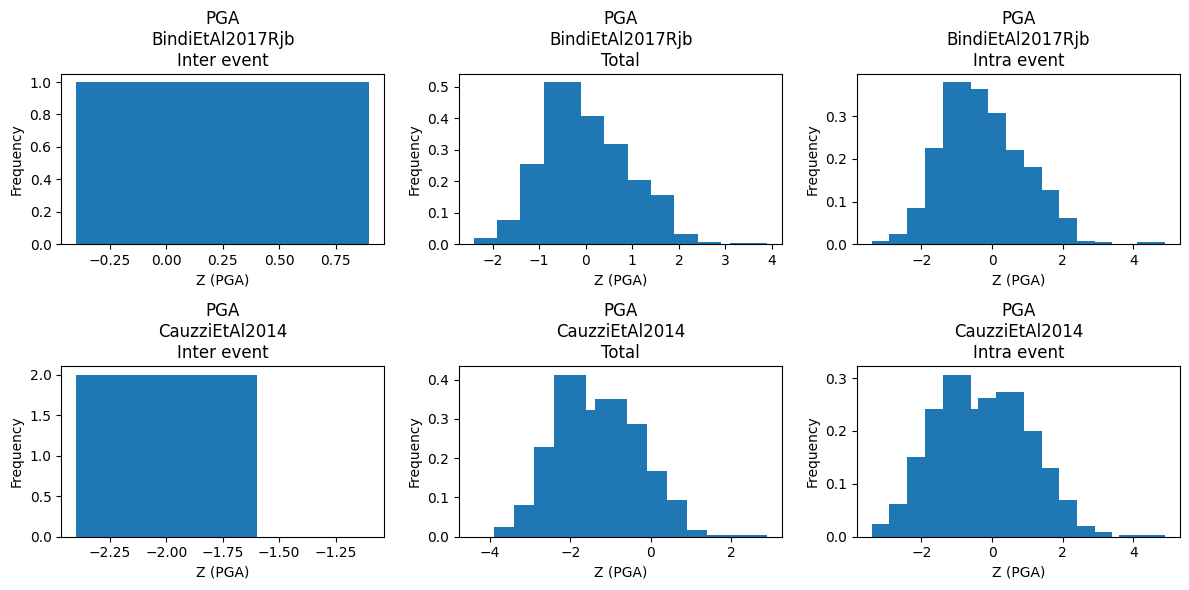

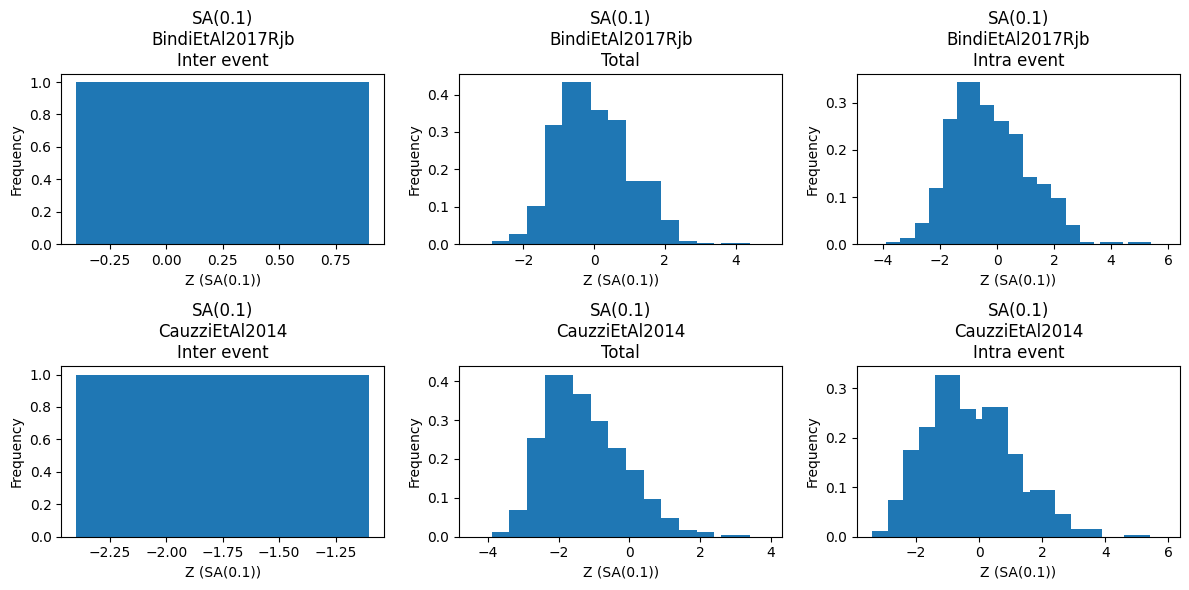

In [4]:
# let's plot the data
for imt, imt_data in json_response.items():
    # print(f'Intensity measure: {imt}')
    fig = plt.figure(figsize=(12, 6))
    # prepare subplots grid (3=types of residuals: inter, intra and total):
    ax = fig.subplots(len(models), 3, squeeze=False)
    # iterate over each item and plot:
    for col, (res_type, res_data) in enumerate(imt_data.items()):
        for row, (model, model_data) in enumerate(res_data.items()):
            ax_ = ax[row][col]
            ax_.set_title(f'{imt}\n{model}\n{res_type}')
            ax_.set_xlabel(model_data['xlabel'])
            ax_.set_ylabel(model_data['ylabel'])
            ax_.bar(model_data['xvalues'], model_data['yvalues'])

    plt.tight_layout()

## Residuals request (scatter plot vs. magnitude)

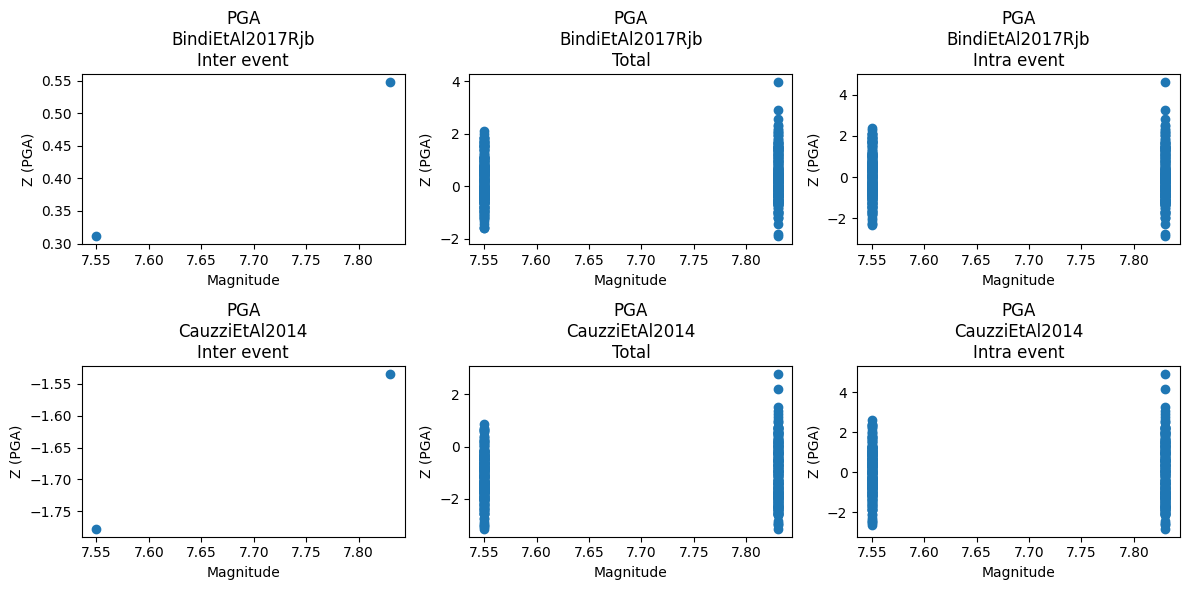

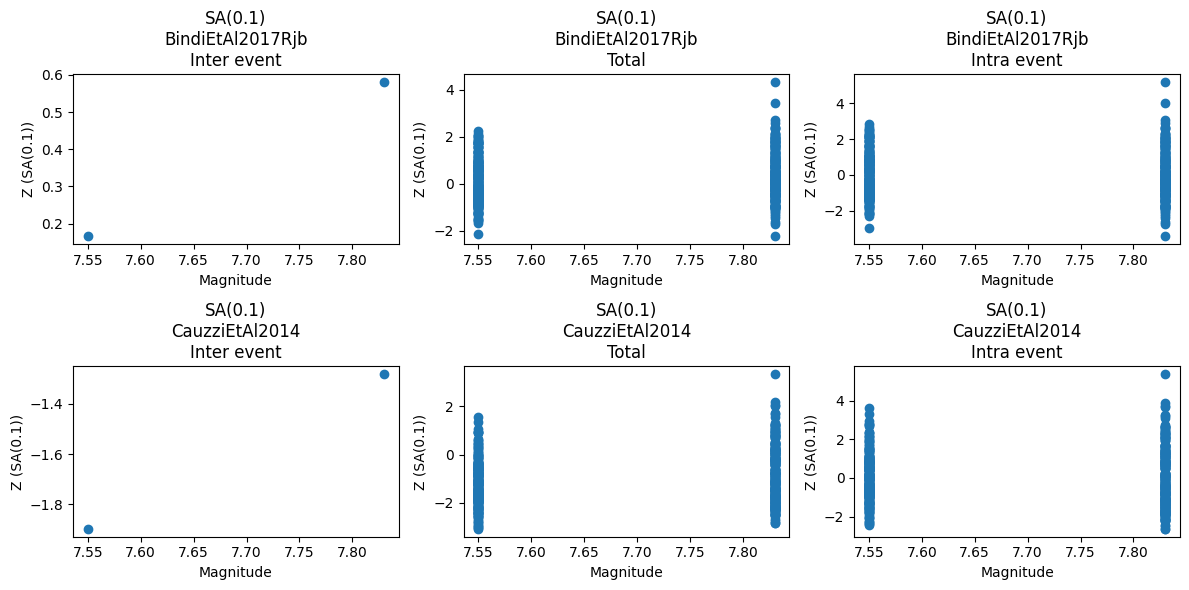

In [5]:
# Removing comments (for details, see axamples above)

with open(flatfile_path,'rb') as flatfile:
    try:
        json_response = None
        files = {'flatfile': flatfile}
        parameters = {'model': models, 'imt': imts, 'plot': 'mag'}
        response = requests.post(url, files=files, data=parameters)
        json_response = response.json()
        response.raise_for_status()
    except Exception:
        raise    

for imt, imt_data in json_response.items():
    fig = plt.figure(figsize=(12, 6))
    ax = fig.subplots(len(models), 3, squeeze=False)
    for col, (res_type, res_data) in enumerate(imt_data.items()):
        for row, (model, model_data) in enumerate(res_data.items()):
            ax_ = ax[row][col]
            ax_.set_title(f'{imt}\n{model}\n{res_type}')
            ax_.set_xlabel(model_data['xlabel'])
            ax_.set_ylabel(model_data['ylabel'])
            ax_.scatter(model_data['xvalues'], model_data['yvalues'])

    plt.tight_layout()